这篇文章是将cs231n中LSTM_Caption重新敲了一遍，所有的模块放在一起，以便于系统的理解整个过程。目的是读懂其中的每一行代码，即使是课程中已经帮你写好了的。

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#### 自动加载模块

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### 1. 下载数据

In [3]:
from builtins import range
import os, json
import numpy as np
import h5py

BASE_DIR = 'cs231n/datasets/coco_captioning'

def load_coco_data(base_dir=BASE_DIR,
                   max_train=None,
                   pca_features=True):
    """
    从本地磁盘获取数据，生成的数据集包括：(captions, features, URLs, and vocabulary) 
    - captions:图像标题经过分词后得到的
    - features:图像特征
    - URLs:图像对应的网络链接。因为图片占内存太大，因而只存储其链接
    - vovabulary:词典
    
    输入:
    - pca_features:　图像特征是否经过降维处理。图像是通过VGG-16 network在ImageNet训练过后提取的特征。
    　这些图像特征分别存储在train2014_vgg16_fc7.h5 和 val2014_vgg16_fc7.h5 文件中。通过pca降维
      处理后的特征放在train2014_vgg16_fc7_pca.h5 和 val2014_vgg16_fc7_pca.h5文件中。
    - max_train:
    """
    
    data = {}
    caption_file = os.path.join(base_dir, 'coco2014_captions.h5')
    
    # 获取图像标题数据，注意里面存储的是word对应的Integer ID
    # 请记住h5py.File类似python的词典对象,详细查看链接:http://blog.csdn.net/yudf2010/article/details/50353292
    with h5py.File(caption_file, 'r') as f:
        assert(list(f.keys())==['train_captions', 'train_image_idxs', 'val_captions', 'val_image_idxs'])
        for k, v in f.items(): 
            data[k] = np.asarray(v)
    
    # 获取图像特征:
    if pca_features:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7_pca.h5')
    else:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7.h5')
    with h5py.File(train_feat_file, 'r') as f:
        assert(list(f.keys())==['features'])
        data['train_features'] = np.asarray(f['features'])    
    if pca_features:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7_pca.h5')
    else:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7.h5')
    with h5py.File(val_feat_file, 'r') as f:
        data['val_features'] = np.asarray(f['features'])
    
    # 获取词典
    # 关于json详细可查看python3-cookbook:http://python3-cookbook.readthedocs.io/zh_CN/latest/c06/p02_read-write_json_data.html
    dict_file = os.path.join(base_dir, 'coco2014_vocab.json')
    with open(dict_file, 'r') as f:
        dict_data = json.load(f)
        for k, v in dict_data.items():
            data[k] = v
    
    # 获取图像链接
    train_url_file = os.path.join(base_dir, 'train2014_urls.txt')
    with open(train_url_file, 'r') as f:
        train_urls = np.asarray([line.strip() for line in f])
    data['train_urls'] = train_urls
    val_url_file = os.path.join(base_dir, 'val2014_urls.txt')
    with open(val_url_file, 'r') as f:
        val_urls = np.asarray([line.strip() for line in f])
    data['val_urls'] = val_urls
    
    # 对训练数据进行采样，随机选取图片以及其对应的标题
    if max_train is not None:   ## max_train表示训练集样本数
        num_train = data['train_captions'].shape[0]
        mask = np.random.randint(num_train, size=max_train)
        data['train_captions'] = data['train_captions'][mask]
        data['train_image_idxs'] = data['train_image_idxs'][mask]
    
    return data

data = load_coco_data(BASE_DIR)
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))    

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


### 2. LSTM

#### 2.1  LSTM step forward

这个图是来自Ng的courser课程作业中的截图。虽然Ng的课程作业相比cs231n的作业太简单了，完全的手把手的教。。感觉不太好，很多东西模块化了看不到，不知道具体细节。但是Ng的课讲的确实是好！而且里面的图画的也很好，就借鉴过来了～但符号标注跟cs231n不太一样，不过能理解就没问题！
![这里写图片描述](http://img.blog.csdn.net/20180309113952226?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcGFueGlhb3hpZQ==/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)


>LSTM相比vanilla RNN，由于重复矩阵乘法导致消失和爆炸梯度，因此vanilla RNN可能很难训练长序列。LSTM通过用选通机制代替vanilla RNN的简单更新规则来解决这个问题。

>代码与上图中的符号不太一致。图中隐藏层用$a^{<t-1>}，a^{<t>}$表示，而在代码中用prev_h和next_h表示。代码中的a表示为经过激活函数的gate.
然后经过激活函数:ai表示更新门$\sigma_u$, af表示遗忘门$\sigma_f$, ao表示输出门$\sigma_o$，ag要更新的memory cell即$\tilde c^{<t>}$，next_c表示新的memory cell状态。

In [26]:
def sigmoid(x):
    """
    A numerically stable version of the logistic sigmoid function.
    """
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])  ###　大于０的加符号，小于０的不加。。为啥？
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)

def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b):
    """
    Forward pass for a single timestep of an LSTM.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H)
    - prev_c: previous cell state, of shape (N, H)
    - Wx: Input-to-hidden weights, of shape (D, 4H)
    - Wh: Hidden-to-hidden weights, of shape (H, 4H)
    - b: Biases, of shape (4H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    - cache: Tuple of values needed for backward pass.
    """
    next_h, next_c, cache = None, None, None
    #############################################################################
    # TODO: Implement the forward pass for a single timestep of an LSTM.        #
    # You may want to use the numerically stable sigmoid implementation above.  #
    #############################################################################
    N, H = prev_h.shape
    a = x.dot(Wx) + prev_h.dot(Wh) + b  # (N, 4H)
    
    # compute gate
    ai = a[:, :H]
    af = a[:, H:2*H]
    ao = a[:, 2*H:3*H]
    ag = a[:, 3*H:]
    gate_i = sigmoid(ai)        # update gate
    gate_f = sigmoid(af)        # forget gate
    gate_o = sigmoid(ao)        # output gate
    gate_g = np.tanh(ag)        # c_tilde
    
    next_c = gate_i * gate_g + gate_f * prev_c   # new cell state (N, H)
    next_h = gate_o * np.tanh(next_c)
    cache = (x, prev_h, prev_c, Wx, Wh, b, next_c, ai, af, ao, ag, gate_i, gate_f, gate_o, gate_g)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return next_h, next_c, cache

#### 2.2  LSTM step backward

>通过链式求导一步步计算即可。但需要注意的一点是对于lstm_step_backward()这个函数其输入dnext_h是包括损失函数求导得到的梯度加上下一层回流的梯度。

>同样的道理记忆细胞也会forward到下一层，并参与到这一层输出损失函数。因此其梯度也包括两部分。这个函数中dnext_c是下一层回流的梯度，因此需要加上当前层损失函数求导得到的梯度。

![这里写图片描述](http://img.blog.csdn.net/20180309173626389?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcGFueGlhb3hpZQ==/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)


这个图是cs231n中的图，$\odot$表示点乘。这个图跟上一个图是一样的，不过门机制中的激活函数没有表示出来，都画得棒棒的～～

$tanh(x) = \dfrac{sinh(x)}{cosh(x)} = \dfrac{e^x-e^{-x}}{e^x+e^{-x}}\quad$
求导可得：$\dfrac{\partial tanh(x)}{\partial x} = 1-(tanh(x))^2$

$\sigma (x) = \dfrac{1}{1+e^{-x}}\quad$ 
求导可得：$\dfrac{\partial \sigma(x)}{\partial x} = \sigma (x)(1-\sigma (x))$

In [5]:
def lstm_step_backward(dnext_h, dnext_c, cache):
    """
    Backward pass for a single timestep of an LSTM.

    Inputs:
    - dnext_h: Gradients of next hidden state, of shape (N, H)
    - dnext_c: Gradients of next cell state, of shape (N, H)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient of input data, of shape (N, D)
    - dprev_h: Gradient of previous hidden state, of shape (N, H)
    - dprev_c: Gradient of previous cell state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, 4H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, 4H)
    - db: Gradient of biases, of shape (4H,)
    """
    dx, dh, dc, dWx, dWh, db = None, None, None, None, None, None
    #############################################################################
    # TODO: Implement the backward pass for a single timestep of an LSTM.       #
    #                                                                           #
    # HINT: For sigmoid and tanh you can compute local derivatives in terms of  #
    # the output value from the nonlinearity.                                   #
    #############################################################################
    N, H = dnext_h.shape
    # unroll cache
    x, prev_h, prev_c, Wx, Wh, b, next_c, ai, af, ao, ag, gate_i, gate_f, gate_o, gate_g = cache
    
    dgate_o = dnext_h * np.tanh(next_c)
    # 除了在这个时间步生成损失函数回流的梯度dh/dnext_c，还有上一层cell memory回流的梯度dnext_c
    dnext_c += dnext_h * gate_o * (1 - np.tanh(next_c)**2)
    
    dgate_i = dnext_c * gate_g
    dgate_f = dnext_c * prev_c
    dgate_g = dnext_c * gate_i
    dprev_c = dnext_c * gate_f    # dprev_c  (N, H)
       
    dai = gate_i * (1 - gate_i) * dgate_i
    daf = gate_f * (1 - gate_f) * dgate_f
    dao = gate_o * (1 - gate_o) * dgate_o
    dag = (1 - gate_g**2) * dgate_g
    
    da = np.hstack((dai, daf, dao, dag)) # (N ,4H)
    assert(da.shape == (N, 4*H))
    
    dx = da.dot(Wx.T)         # dx (N, D)
    dWx = x.T.dot(da)         # dWx  (D, 4H)
    dprev_h = da.dot(Wh.T)    # dprev_h  (N, H)
    dWh = prev_h.T.dot(da)    # dWh (H, 4H)    
    db = np.sum(da, axis=0)   # db (1, 4H)
    pass
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return dx, dprev_h, dprev_c, dWx, dWh, db

![这里写图片描述](http://img.blog.csdn.net/20180309162831167?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcGFueGlhb3hpZQ==/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

![这里写图片描述](http://img.blog.csdn.net/20180309172734983?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcGFueGlhb3hpZQ==/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

这两图从两个角度表示了完成的RNN过程，上面的一个更宏观。

#### 2.3 LSTM forward

>前向传播都是比较简单的，这里需要注意的是记忆细胞的初始值设为0, h0这里是作为输入。因为这篇文章是针对图像标注的，之后图像特征会赋值给h0。如果是其他模型一般也是设为0．

In [6]:
def lstm_forward(x, h0, Wx, Wh, b):
    """
    Forward pass for an LSTM over an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the LSTM forward, we return the hidden states for all timesteps.

    Note that the initial cell state is passed as input, but the initial cell
    state is set to zero. Also note that the cell state is not returned; it is
    an internal variable to the LSTM and is not accessed from outside.

    Inputs:
    - x: Input data of shape (N, T, D)
    - h0: Initial hidden state of shape (N, H)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases of shape (4H,)

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    - cache: Values needed for the backward pass.
    """
    h, cache = None, None
    #############################################################################
    # TODO: Implement the forward pass for an LSTM over an entire timeseries.   #
    # You should use the lstm_step_forward function that you just defined.      #
    #############################################################################
    N, T, D = x.shape
    N, H = h0.shape
    h = np.zeros((N, T, H))
    c = np.zeros((N, T, H))
    cache = []
    next_h = h0
    next_c = np.zeros((N ,H))
    for t in range(T):
        next_h, next_c, cache_t = lstm_step_forward(x[:,t,:], next_h, next_c, Wx, Wh, b) # 权重参数共享
        h[:, t, :] = next_h
        c[:, t, :] = next_c
        cache.append(cache_t)    
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return h, cache

#### 2.4 LSTM backward

>完整的整个时间序列上的反向传播.需要注意的是参数dh是指的通过对每个时间步损失函数求导得到的(N,T,H)，显然不包括下一层回流的梯度，因为你压根不知道呀～而在lstm_step_backward中dnext_h没有累加，因为它只考虑了一个时间步，故其dh只需要损失函数回流的即可。

In [24]:
def lstm_backward(dh, cache):
    """
    Backward pass for an LSTM over an entire sequence of data.]

    Inputs:
    - dh: Upstream gradients of hidden states, of shape (N, T, H)  ###　损失函数得到的梯度
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient of input data of shape (N, T, D)
    - dh0: Gradient of initial hidden state of shape (N, H)
    - dWx: Gradient of input-to-hidden weight matrix of shape (D, 4H)
    - dWh: Gradient of hidden-to-hidden weight matrix of shape (H, 4H)
    - db: Gradient of biases, of shape (4H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    #############################################################################
    # TODO: Implement the backward pass for an LSTM over an entire timeseries.  #
    # You should use the lstm_step_backward function that you just defined.     #
    #############################################################################
    
    assert(len(cache[0])==15)
    x, prev_h, prev_c, Wx, Wh, b, next_c, ai, af, ao, ag, gate_i, gate_f, gate_o, gate_g = cache[0]
    N, T, H = dh.shape
    N, D = x.shape
    
    # initilizate
    dx = np.zeros((N, T, D))
    dh0 = np.zeros((N, H))
    dWx = np.zeros((D, 4*H))
    dWh = np.zeros((H, 4*H))
    db = np.zeros((4*H,))
    
    # 隐藏层迭代的
    dnext_h = np.zeros((N, H))
    dnext_c = np.zeros_like(dnext_h)
    
    for k in range(T):
        t = T-1-k
        # 隐藏层h的梯度不仅来源于损失函数计算得到的dh[:,t,:]，而且有上一层回流的梯度dnext_h
        # 记忆细胞也是这样，但在step backward中已经考虑到了两种回流
        dnext_h += dh[:,t,:]
        dx_t, dnext_h, dnext_c, dWx_t, dWh_t, db_t = lstm_step_backward(dnext_h, dnext_c, cache[t])
        dx[:,t,:] = dx_t
        # 参数是共享的
        dWx += dWx_t
        dWh += dWh_t
        db += db_t
        
    dh0 = dnext_h
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return dx, dh0, dWx, dWh, db

### 3. LSTM Caption Model

>前面的部分只是考虑了隐藏层。还需要从训练数据到隐藏的输入以及从隐藏层的输出到损失函数loss，才能构成完整的模型。

>整个结构：
- 全连接层：图像特征提取，作为RNN的隐藏层的第一个输入h0。(N, input_dim)-> (N, H)
- 词向量层：将原始标题数据转化为对应的词向量.  (N, T)->(N, T, D)
- rnn层：vanilla RNN or LSTM.  (N, T, D)->(N, T, H)
- 全连接层：从隐藏层的输出到每个时间步的输出在词典V中所有词的得分。 (N, T, H)->(N, T, V)
- 损失函数：计算loss,并返回梯度shape=(N ,T, V)然后进行反向传播～

>需要注意的是：
训练和测试时是不一样的。

#### 3.1  词向量层
原始captions数据(N,T)转化为隐藏层的输入(N, T, D)  D是词向量的维度～

重点是：broadcasting 和 np.add,at() 

In [8]:
def word_embedding_forward(x, W):
    """
    Forward pass for word embeddings. We operate on minibatches of size N where
    each sequence has length T. We assume a vocabulary of V words, assigning each
    to a vector of dimension D.

    Inputs:
    - x: Integer array of shape (N, T) giving indices of words. Each element idx
      of x must be in the range 0 <= idx < V.
    - W: Weight matrix of shape (V, D) giving word vectors for all words.　### 预训练好的词向量

    Returns a tuple of:
    - out: Array of shape (N, T, D) giving word vectors for all input words.
    - cache: Values needed for the backward pass
    """
    out, cache = None, None
    out = W[x,:]   ##numpy的广播机制，将x的每一个元素带进去，然后取对应的词向量
    cache = (x, W)
    return out, cache

def word_embedding_backward(dout, cache):
    """
    Backward pass for word embeddings. We cannot back-propagate into the words
    since they are integers, so we only return gradient for the word embedding
    matrix.

    HINT: Look up the function np.add.at

    Inputs:
    - dout: Upstream gradients of shape (N, T, D)
    - cache: Values from the forward pass

    Returns:
    - dW: Gradient of word embedding matrix, of shape (V, D).
    """
    dW = None
    x, W = cache    # x.shape=(N, T)
    dW=np.zeros_like(W) # W.shape=(V, D)
    # 在x指定的位置将dout加到dW上
    np.add.at(dW, x, dout) # dout.shape(N, T, D)
    return dW

#### 3.2 rnn层

就是前面lstm的前、反向传播。隐藏层：从输入(N, T, D)到输出(N, T, H)

#### 3.3 temporal_affine层
从(N, T, H)到(N, T, V),表示每个时间步的输出在词典V中所有词的得分，这个符号与整体是一致的。下面的代码中符号不太准确。

In [9]:
def temporal_affine_forward(x, w, b):
    """
    Forward pass for a temporal affine layer. The input is a set of D-dimensional
    vectors arranged into a minibatch of N timeseries, each of length T. We use
    an affine function to transform each of those vectors into a new vector of
    dimension M.

    Inputs:
    - x: Input data of shape (N, T, D)  ##　时间t时刻对应的minibatch个词向量(N, T, D)
    - w: Weights of shape (D, M)
    - b: Biases of shape (M,)

    Returns a tuple of:
    - out: Output data of shape (N, T, M)
    - cache: Values needed for the backward pass
    """
    N, T, D = x.shape
    M = b.shape[0]
    out = x.reshape(N * T, D).dot(w).reshape(N, T, M) + b
    cache = x, w, b, out
    return out, cache

def temporal_affine_backward(dout, cache):
    """
    Backward pass for temporal affine layer.

    Input:
    - dout: Upstream gradients of shape (N, T, M)
    - cache: Values from forward pass

    Returns a tuple of:
    - dx: Gradient of input, of shape (N, T, D)
    - dw: Gradient of weights, of shape (D, M)
    - db: Gradient of biases, of shape (M,)
    """
    x, w, b, out = cache
    N, T, D = x.shape
    M = b.shape[0]

    dx = dout.reshape(N * T, M).dot(w.T).reshape(N, T, D)
    dw = dout.reshape(N * T, M).T.dot(x.reshape(N * T, D)).T
    db = dout.sum(axis=(0, 1))

    return dx, dw, db


#### 3.3 temporal_softmax层

损失函数：计算loss,并返回梯度shape=(N ,T, V)然后进行反向传播～

其中序列长度为T，但不是所有的caption长度都满足，因此不足的用NULL补充，尽管在训练时，这些时间步也会得到score,但真实值并不是NULL，因此不需要计算loss.　用mask解决这个问题,mask是(N, T, D)由0,1构成
```pyhton 
mask = (captions_out != self._null)```

In [14]:
def temporal_softmax_loss(x, y, mask, verbose=False):
    """
    A temporal version of softmax loss for use in RNNs. We assume that we are
    making predictions over a vocabulary of size V for each timestep of a
    timeseries of length T, over a minibatch of size N. The input x gives scores
    for all vocabulary elements at all timesteps, and y gives the indices of the
    ground-truth element at each timestep. We use a cross-entropy loss at each
    timestep, summing the loss over all timesteps and averaging across the
    minibatch.

    As an additional complication, we may want to ignore the model output at some
    timesteps, since sequences of different length may have been combined into a
    minibatch and padded with NULL tokens. The optional mask argument tells us
    which elements should contribute to the loss.

    Inputs:
    - x: Input scores, of shape (N, T, V)
    - y: Ground-truth indices, of shape (N, T) where each element is in the range
         0 <= y[i, t] < V
    - mask: Boolean array of shape (N, T) where mask[i, t] tells whether or not
      the scores at x[i, t] should contribute to the loss.

    Returns a tuple of:
    - loss: Scalar giving loss
    - dx: Gradient of loss with respect to scores x.
    """

    N, T, V = x.shape

    x_flat = x.reshape(N * T, V)    # 类似于图像一样，也要拉长～计算每个词(None,V)与真实值的交叉熵损失loss
    y_flat = y.reshape(N * T)
    mask_flat = mask.reshape(N * T)   # (N ,T, D)->(N*T, D)

    probs = np.exp(x_flat - np.max(x_flat, axis=1, keepdims=True))  # 避免数值溢出
    probs /= np.sum(probs, axis=1, keepdims=True)
    loss = -np.sum(mask_flat * np.log(probs[np.arange(N * T), y_flat])) / N
    
    dx_flat = probs.copy()
    dx_flat[np.arange(N * T), y_flat] -= 1
    dx_flat /= N
    dx_flat *= mask_flat[:, None]   # 

    if verbose: print('dx_flat: ', dx_flat.shape)

    dx = dx_flat.reshape(N, T, V)  # 每个时间步对应的梯度

    return loss, dx

### 3.4 caption model

In [15]:
class CaptioningRNN(object):
    """
    A CaptioningRNN produces captions from image features using a recurrent
    neural network.

    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.

    Note that we don't use any regularization for the CaptioningRNN.
    """

    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
                 hidden_dim=128, cell_type='rnn', dtype=np.float32):
        """
        Construct a new CaptioningRNN instance.

        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.　　### 图像的特征向量
        - wordvec_dim: Dimension W of word vectors.　　　###词向量维度
        - hidden_dim: Dimension H for the hidden state of the RNN.　　###隐藏层
        - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.　###神经元状态rnn or lstm
        - dtype: numpy datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.dtype = dtype
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}  ###idx_to_word
        self.params = {}

        vocab_size = len(word_to_idx)  ## 词典大小

        ### ３个特殊字符的索引
        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)  # 用None表示START和END
        self._end = word_to_idx.get('<END>', None)

        # Initialize word vectors　初始化词向量
        self.params['W_embed'] = np.random.randn(vocab_size, wordvec_dim)  ## (V, W)
        self.params['W_embed'] /= 100  ##???

        # Initialize CNN -> hidden state projection parameters  根据图像生成的特征向量到第一个隐藏层的矩阵初始化
        self.params['W_proj'] = np.random.randn(input_dim, hidden_dim)
        self.params['W_proj'] /= np.sqrt(input_dim)  ### 使得生成的初始权重的方差为0.2?
        self.params['b_proj'] = np.zeros(hidden_dim)

        # Initialize parameters for the RNN　　初始化RNN参数
        dim_mul = {'lstm': 4, 'rnn': 1}[cell_type]  
        self.params['Wx'] = np.random.randn(wordvec_dim, dim_mul * hidden_dim)
        self.params['Wx'] /= np.sqrt(wordvec_dim)
        self.params['Wh'] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
        self.params['Wh'] /= np.sqrt(hidden_dim)
        self.params['b'] = np.zeros(dim_mul * hidden_dim)

        # Initialize output to vocab weights 从隐藏层到输出词之间的矩阵初始化
        self.params['W_vocab'] = np.random.randn(hidden_dim, vocab_size)  # (H,V)
        self.params['W_vocab'] /= np.sqrt(hidden_dim)
        self.params['b_vocab'] = np.zeros(vocab_size)

        # Cast parameters to correct dtype
        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)

    def loss(self, features, captions):
        """
        Compute training-time loss for the RNN. We input image features and
        ground-truth captions for those images, and use an RNN (or LSTM) to compute
        loss and gradients on all parameters.

        Inputs:
        - features: Input image features, of shape (N, D)　## 输入是图像的特征向量(N, D)
        - captions: Ground-truth captions; an integer array of shape (N, T) where
          each element is in the range 0 <= y[i, t] < V  ## 真实标签是标题对应在字典中的索引(N, T)

        Returns a tuple of:
        - loss: Scalar loss
        - grads: Dictionary of gradients parallel to self.params
        """
        # Cut captions into two pieces: captions_in has everything but the last word
        # and will be input to the RNN; captions_out has everything but the first
        # word and this is what we will expect the RNN to generate. These are offset
        # by one relative to each other because the RNN should produce word (t+1)
        # after receiving word t. The first element of captions_in will be the START
        # token, and the first element of captions_out will be the first word.
        
        ## 这里将captions分成了两个部分，captions_in是除了最后一个词外的所有词，是输入到RNN/LSTM的输入；
        ## captions_out是除了第一个词外的所有词，是RNN/LSTM期望得到的输出。
        captions_in = captions[:, :-1]  #(N,T)而不是T-1，T是自己定的嘛，不是一定就得和整个句子长度一致，输入和输出都是T就没问题
        captions_out = captions[:, 1:]  #真实值

        # You'll need this
        mask = (captions_out != self._null)

        # Weight and bias for the affine transform from image features to initial
        # hidden state
        # 从图像特征到初始隐藏状态的权值矩阵和偏差值 
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']

        # Word embedding matrix
        # 词嵌入矩阵
        W_embed = self.params['W_embed']

        # Input-to-hidden, hidden-to-hidden, and biases for the RNN
        # RNN/LSTM参数
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']

        # Weight and bias for the hidden-to-vocab transformation.
        # 每一隐藏层到输出的权值矩阵和偏差
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the forward and backward passes for the CaptioningRNN.   #
        # In the forward pass you will need to do the following:                   #
        # (1) Use an affine transformation to compute the initial hidden state     #
        #     from the image features. This should produce an array of shape (N, H)#
        # (2) Use a word embedding layer to transform the words in captions_in     #
        #     from indices to vectors, giving an array of shape (N, T, W).         #
        # (3) Use either a vanilla RNN or LSTM (depending on self.cell_type) to    #
        #     process the sequence of input word vectors and produce hidden state  #
        #     vectors for all timesteps, producing an array of shape (N, T, H).    #
        # (4) Use a (temporal) affine transformation to compute scores over the    #
        #     vocabulary at every timestep using the hidden states, giving an      #
        #     array of shape (N, T, V).                                            #
        # (5) Use (temporal) softmax to compute loss using captions_out, ignoring  #
        #     the points where the output word is <NULL> using the mask above.     #
        #                                                                          #
        # In the backward pass you will need to compute the gradient of the loss   #
        # with respect to all model parameters. Use the loss and grads variables   #
        # defined above to store loss and gradients; grads[k] should give the      #
        # gradients for self.params[k].                                            #
        ############################################################################
        
        ## step1: 图像特征到隐藏层：全连接层
        h0 = np.dot(features, W_proj) + b_proj  # (N,H)
        
        ## step2: 将输入序列转换为词向量
        embed_out, cache_embed = word_embedding_forward(captions_in, W_embed)  # (N ,T, W)
        
        ## step3: 将图像特征和词向量作为输入，通过RNN,得到隐藏层的输出
        if self.cell_type == 'rnn':
            hidden_out, cache_hidden = rnn_forward(embed_out, h0, Wx, Wh, b) 
        elif self.cell_type == 'lstm':
            hidden_out, cache_hidden = lstm_forward(embed_out, h0, Wx, Wh, b)
            assert(len(cache_hidden[0])==15)
        else:
            raise ValueError('%s not implemented' % (self.cell_type))
        
        ## step4: 将隐藏层的输出作为输入，通过affine-softmax层得到输出，词典中每个词的得分
        score_vocab, cache_vocab = temporal_affine_forward(hidden_out, W_vocab, b_vocab)  # (N, T, V)
        
        # 用softmax函数计算损失，真实值为captions_out, 用mask忽视所有向量中<NULL>词汇
        loss, dscore_vocab = temporal_softmax_loss(score_vocab, captions_out, mask, verbose=False)

        ## 反向传播计算梯度
        grads = dict.fromkeys(self.params)
        
        # step4 backward
        dhidden_out, dW_vocab, db_vocab = temporal_affine_backward(dscore_vocab, cache_vocab)
        grads['W_vocab'] = dW_vocab
        grads['b_vocab'] = db_vocab

        # Backward into step 3
        if self.cell_type == 'rnn':
            dembed_out, dh0, dWx, dWh, db = rnn_backward(dhidden_out, cache_hidden)
        elif self.cell_type == 'lstm':
            assert(len(cache_hidden[0])==15)
            dembed_out, dh0, dWx, dWh, db = lstm_backward(dhidden_out, cache_hidden)
        else:
            raise ValueError('%s not implemented' % (self.cell_type))
        grads['Wx'] = dWx
        grads['Wh'] = dWh
        grads['b'] = db

        # Backward into step 2
        dW_embed = word_embedding_backward(dembed_out, cache_embed)
        grads['W_embed'] = dW_embed
        
        ## aBackward into step 1
        dW_proj = features.T.dot(dh0)
        db_proj = np.sum(dh0,axis=0)
        grads['W_proj'] = dW_proj
        grads['b_proj'] = db_proj
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

    def sample(self, features, max_length=30):
        """
        Run a test-time forward pass for the model, sampling captions for input
        feature vectors.

        At each timestep, we embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state is computed by applying an affine
        transform to the input image features, and the initial word is the <START>
        token.

        For LSTMs you will also have to keep track of the cell state; in that case
        the initial cell state should be zero.

        Inputs:
        - features: Array of input image features of shape (N, D).
        - max_length: Maximum length T of generated captions.

        Returns:
        - captions: Array of shape (N, max_length) giving sampled captions,
          where each element is an integer in the range [0, V). The first element
          of captions should be the first sampled word, not the <START> token.
        """
        N = features.shape[0]
        captions = self._null * np.ones((N, max_length), dtype=np.int32)

        # Unpack parameters
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']
        W_embed = self.params['W_embed']
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        ###########################################################################
        # TODO: Implement test-time sampling for the model. You will need to      #
        # initialize the hidden state of the RNN by applying the learned affine   #
        # transform to the input image features. The first word that you feed to  #
        # the RNN should be the <START> token; its value is stored in the         #
        # variable self._start. At each timestep you will need to do to:          #
        # (1) Embed the previous word using the learned word embeddings           #
        # (2) Make an RNN step using the previous hidden state and the embedded   #
        #     current word to get the next hidden state.                          #
        # (3) Apply the learned affine transformation to the next hidden state to #
        #     get scores for all words in the vocabulary                          #
        # (4) Select the word with the highest score as the next word, writing it #
        #     to the appropriate slot in the captions variable                    #
        #                                                                         #
        # For simplicity, you do not need to stop generating after an <END> token #
        # is sampled, but you can if you want to.                                 #
        #                                                                         #
        # HINT: You will not be able to use the rnn_forward or lstm_forward       #
        # functions; you'll need to call rnn_step_forward or lstm_step_forward in #
        # a loop.                                                                 #
        ###########################################################################
        
        ## step1: 图像特征到隐藏层：全连接层
        N, D = features.shape
        H, V = W_vocab.shape
        V, W = W_embed.shape
        
        h0 = np.dot(features, W_proj) + b_proj  # (N,H)
        assert(h0.shape==(N,H))
        
        captions[:,0] = self._start 
        
        prev_h = h0 # Previous hidden state
        prev_c = np.zeros(h0.shape)  # lstm: memory cell state
        # Current word (start word)
        x = self._start * np.ones((N, 1), dtype=np.int32)  # (N,1) 测试：sample时输入
        
        for t in range(max_length):
            embed_out, _ = word_embedding_forward(x, W_embed)  # (N ,1, W) embedded word vector
            assert(embed_out.shape == (N,1,W))
            if self.cell_type == 'rnn':
                # Run a step of rnn   # Remove single-dimensional entries from the shape of an array.
                hidden_out, _ = rnn_step_forward(np.squeeze(embed_out), prev_h, Wx, Wh, b)   ## (N,H)                
            elif self.cell_type == 'lstm':
                # Run a step of lstm
                hidden_out, _, _ = lstm_step_forward(np.squeeze(embed_out), prev_h, prev_c, Wx, Wh, b)
            else:
                raise ValueError('%s not implemented' % (self.cell_type))
        
        # Compute the score distrib over the dictionary      
        score_vocab, cache_vocab = temporal_affine_forward(hidden_out[:, np.newaxis, :], W_vocab, b_vocab)  # (N, 1, V)
        # Squeeze unecessari dimension and get the best word idx
        idx_best = np.squeeze(np.argmax(score_vocab, axis=2))
        # Put it in the captions
        captions[:, t] = idx_best
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return captions

### ４.训练模型

#### 4.1 优化算法

In [16]:
def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config


def adam(x, dx, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(x))
    config.setdefault('v', np.zeros_like(x))
    config.setdefault('t', 0)

    next_x = None
    beta1, beta2, eps = config['beta1'], config['beta2'], config['epsilon']
    t, m, v = config['t'], config['m'], config['v']
    m = beta1 * m + (1 - beta1) * dx
    v = beta2 * v + (1 - beta2) * (dx * dx)
    t += 1
    alpha = config['learning_rate'] * np.sqrt(1 - beta2 ** t) / (1 - beta1 ** t)
    x -= alpha * (m / (np.sqrt(v) + eps))
    config['t'] = t
    config['m'] = m
    config['v'] = v
    next_x = x

    return next_x, config

#### 4.2 小批量梯度下降

In [17]:
def sample_coco_minibatch(data, batch_size=100, split='train'):
    split_size = data['%s_captions' % split].shape[0]
    mask = np.random.choice(split_size, batch_size)
    captions = data['%s_captions' % split][mask]
    image_idxs = data['%s_image_idxs' % split][mask]
    image_features = data['%s_features' % split][image_idxs]
    urls = data['%s_urls' % split][image_idxs]
    return captions, image_features, urls

In [18]:
from cs231n import optim
class CaptioningSolver(object):
    """
    A CaptioningSolver encapsulates all the logic necessary for training
    image captioning models. The CaptioningSolver performs stochastic gradient
    descent using different update rules defined in optim.py.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a CaptioningSolver instance,
    passing the model, dataset, and various options (learning rate, batch size,
    etc) to the constructor. You will then call the train() method to run the
    optimization procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists containing
    the accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = load_coco_data()
    model = MyAwesomeModel(hidden_dim=100)
    solver = CaptioningSolver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A CaptioningSolver works on a model object that must conform to the following
    API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(features, captions) must be a function that computes
      training-time loss and gradients, with the following inputs and outputs:

      Inputs:
      - features: Array giving a minibatch of features for images, of shape (N, D
      - captions: Array of captions for those images, of shape (N, T) where
        each element is in the range (0, V].

      Returns:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new CaptioningSolver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data from load_coco_data

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the learning
          rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient during
          training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every print_every
          iterations.
        - verbose: Boolean; if set to false then no output will be printed during
          training.
        """
        self.model = model
        self.data = data

        # Unpack keyword arguments                            ### take a note!!!!
        self.update_rule = kwargs.pop('update_rule', 'sgd')   ### kwargs是一个参数字典，当里面没有'update_rule'时，返回'sgd'
        self.optim_config = kwargs.pop('optim_config', {})    ###　如果给出了'update_rule'
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)

        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not hasattr(optim, self.update_rule):  #判断是否有这个优化算法
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)

        self._reset()


    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.   ### 需要进行优化的变量，不要手动调用
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d


    def _step(self):   ### 被调用一次就执行一步梯度下降，在train()中倍调用，不要手动调用
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        minibatch = sample_coco_minibatch(self.data,
                      batch_size=self.batch_size,
                      split='train')
        captions, features, urls = minibatch

        # Compute loss and gradient
        loss, grads = self.model.loss(features, captions)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)  ###　梯度下降，在optim.py里面
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config


    # TODO: This does nothing right now; maybe implement BLEU?
    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using too
          much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """
        return 0.0

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N / batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc


    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.data['train_captions'].shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch     #总迭代数

        for t in range(num_iterations):
            self._step() ### 每一个batch更新一次梯度

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay the
            # learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay ###　每一个epoch更新一次学习率

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            # TODO: Implement some logic to check Bleu on validation set periodically

        # At the end of training swap the best params into the model
        # self.model.params = self.best_params

(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829101
(Iteration 21 / 100) loss: 30.062620
(Iteration 31 / 100) loss: 14.020130
(Iteration 41 / 100) loss: 6.004623
(Iteration 51 / 100) loss: 1.847776
(Iteration 61 / 100) loss: 0.639553
(Iteration 71 / 100) loss: 0.280834
(Iteration 81 / 100) loss: 0.234212
(Iteration 91 / 100) loss: 0.123417


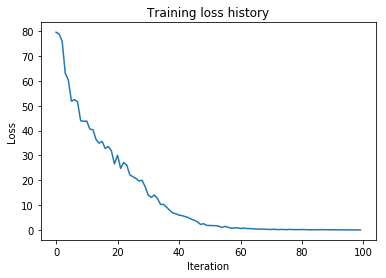

In [27]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()